# Supervised sentiment: Dense feature representations and neural networks

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2019"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Distributed representations as features](#Distributed-representations-as-features)
  1. [GloVe inputs](#GloVe-inputs)
  1. [IMDB representations](#IMDB-representations)
  1. [Remarks on this approach](#Remarks-on-this-approach)
1. [RNN classifiers](#RNN-classifiers)
  1. [RNN dataset preparation](#RNN-dataset-preparation)
  1. [Vocabulary for the embedding](#Vocabulary-for-the-embedding)
  1. [Pure NumPy RNN implementation](#Pure-NumPy-RNN-implementation)
  1. [PyTorch implementation](#PyTorch-implementation)
  1. [TensorFlow implementation](#TensorFlow-implementation)
  1. [Pretrained embeddings](#Pretrained-embeddings)
1. [Tree-structured neural networks](#Tree-structured-neural-networks)
  1. [TreeNN dataset preparation](#TreeNN-dataset-preparation)
  1. [Pure NumPy TreeNN implementation](#Pure-NumPy-TreeNN-implementation)
  1. [Torch TreeNN implementation](#Torch-TreeNN-implementation)

## Overview

This notebook defines and explores __recurrent neural network (RNN) classifiers__ and __tree-structured neural network (TreeNN) classifiers__ for the Stanford Sentiment Treebank. 

These approaches make their predictions based on comprehensive representations of the examples: 

* For the RNN, each word is modeled, as are its sequential relationships to the other words.
* For the TreeNN, the entire parsed structure of the sentence is modeled.

Both models contrast with the ones explored in [the previous notebook](sst_02_hand_built_features.ipynb), which make predictions based on more partial, potentially idiosyncratic information extracted from the examples.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [2]:
from collections import Counter
import numpy as np
import os
import pandas as pd
import random
from np_rnn_classifier import RNNClassifier
from np_tree_nn import TreeNN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import tensorflow as tf
from tf_rnn_classifier import TfRNNClassifier
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import vsm
import utils

In [3]:
# This will limit the TensorFlow log messages to just those
# that track traing progress.

utils.tf_train_progress_logging()

In [4]:
DATE_HOME = 'data'

GLOVE_HOME = os.path.join(DATE_HOME, 'glove.6B')

VSMDATA_HOME = os.path.join(DATE_HOME, 'vsmdata')

SST_HOME = os.path.join(DATE_HOME, 'trees')

## Distributed representations as features

As a first step in the direction of neural networks for sentiment, we can connect with our previous unit on distributed representations. Arguably, more than any specific model architecture, this is the major innovation of deep learning: __rather than designing feature functions by hand, we use dense, distributed representations, often derived from unsupervised models__.

<img src="fig/distreps-as-features.png" width=500 alt="distreps-as-features.png" />

Our model will just be `LogisticRegression`, and we'll continue with the experiment framework from the previous notebook. Here is `fit_maxent_classifier` again:

In [5]:
def fit_maxent_classifier(X, y):   
    mod = LogisticRegression(
        fit_intercept=True, 
        solver='liblinear', 
        multi_class='auto')
    mod.fit(X, y)
    return mod

### GloVe inputs

To illustrate this process, we'll use the general purpose GloVe representations released by the GloVe team, at 50d:

In [6]:
glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [7]:
def vsm_leaves_phi(tree, lookup, np_func=np.sum):
    """Represent `tree` as a combination of the vector of its words.
    
    Parameters
    ----------
    tree : nltk.Tree   
    lookup : dict
        From words to vectors.
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that 
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a 
        fixed length, no matter what the size of the tree is.
    
    Returns
    -------
    np.array, dimension `X.shape[1]`
            
    """      
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])    
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:       
        feats = np_func(allvecs, axis=0)      
    return feats

In [8]:
def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [9]:
_ = sst.experiment(
    SST_HOME,
    glove_leaves_phi,
    fit_maxent_classifier,
    class_func=sst.binary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

Accuracy: 0.779
              precision    recall  f1-score   support

    negative      0.786     0.747     0.766      1005
    positive      0.773     0.809     0.791      1071

   micro avg      0.779     0.779     0.779      2076
   macro avg      0.779     0.778     0.778      2076
weighted avg      0.779     0.779     0.779      2076



### IMDB representations

Our IMDB VSMs seems pretty well-attuned to the Stanford Sentiment Treebank, so we might think that they can do even better than the general-purpose GloVe inputs. Here are two quick assessments of that idea:

In [10]:
imdb20 = pd.read_csv(
    os.path.join(VSMDATA_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)

In [11]:
imdb20_ppmi = vsm.pmi(imdb20, positive=False) 

In [12]:
imdb20_ppmi_svd = vsm.lsa(imdb20_ppmi, k=50) 

In [13]:
imdb_lookup = dict(zip(imdb20_ppmi_svd.index, imdb20_ppmi_svd.values))

In [14]:
def imdb_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, imdb_lookup, np_func=np_func)

In [15]:
_ = sst.experiment(
    SST_HOME,
    imdb_phi,
    fit_maxent_classifier,
    class_func=sst.binary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

Accuracy: 0.737
              precision    recall  f1-score   support

    negative      0.717     0.751     0.733       998
    positive      0.758     0.725     0.742      1078

   micro avg      0.737     0.737     0.737      2076
   macro avg      0.738     0.738     0.737      2076
weighted avg      0.738     0.737     0.738      2076



### Remarks on this approach

* Recall that our `ungrams_phi` created feature representations with over 16K dimensions and got about 0.77.

* The above models have only 50 dimensions and come close in terms of performance. In many ways, it's striking that we can get a model that is competitive with so few dimensions.

* The promise of the Mittens model of [Dingwall and Potts 2018](https://arxiv.org/abs/1803.09901) is that we can use GloVe itself to update the general purpose information in the 'glove.6B' vectors with specialized information from one of these IMDB count matrices. That might be worth trying; the `mittens` package already implements this!

* That said, just summing up all the word representations is pretty unappealing linguistically. There's no doubt that we're losing a lot of valuable information in doing this. The models we turn to now can be seen as addressing this shortcoming while retaining the insight that our distributed representations are valuable for this task.

## RNN classifiers

A recurrent neural network (RNN) is any deep learning model that process its inputs sequentially. There are many variations on this theme. The one that we use here is an __RNN classifier__.

<img src="fig/rnn_classifier.png" width=800 />

For a sequence of length $n$:

$$\begin{align*}
h_{t} &= \tanh(x_{t}W_{xh} + h_{t-1}W_{hh}) \\
y     &= \textbf{softmax}(h_{n}W_{hy} + b)
\end{align*}$$

where $1 \leqslant t \leqslant n$. As indicated in the above diagram, the sequence of hidden states is padded with an initial state $h_{0}$ In our implementations, this is always an all $0$ vector, but it can be initialized in more sophisticated ways (some of which we will explore in our unit on natural language inference).

This is a potential gain over our sum-the-word-vectors baseline, in that it processes each word independently, and in the context of those that came before it. Thus, not only is this sensitive to word order, but the hidden representation give us the potential to encode how the preceding context for a word affects its interpretation.

The downside of this, of course, is that this model is much more difficult to set up and optimize. Let's dive into those details.

### RNN dataset preparation

SST contains trees, but the RNN processes just the sequence of leaf nodes. The function `sst.build_binary_rnn_dataset` creates datasets in this format:

In [16]:
X_rnn_train, y_rnn_train = sst.build_binary_rnn_dataset(
    SST_HOME, sst.train_reader)

Each member of `X_rnn_train` is a list of lists of words. Here's a look at the start of the first:

In [17]:
X_rnn_train[0][: 6]

['The', 'Rock', 'is', 'destined', 'to', 'be']

Because this is a classifier, `y_rnn_train` is just a list of labels, one per example:

In [18]:
y_rnn_train[0]

'positive'

For experiments, let's build a `dev` dataset as well:

In [19]:
X_rnn_dev, y_rnn_dev = sst.build_binary_rnn_dataset(
    SST_HOME, sst.dev_reader)

### Vocabulary for the embedding

The first delicate issue we need to address is the vocabulary for our model:

* As indicated in the figure above, the first thing we do when processing an example is look up the words in an embedding (a VSM), which has to have a fixed dimensionality. 

* We can use our training data to specify the vocabulary for this embedding; at prediction time, though, we will inevitably encounter words we haven't seen before. 

* The convention we adopt here is to map them to an `$UNK` token that is in our pre-specified vocabulary.

* At the same time, we might want to collapse infrequent tokens into `$UNK` to make optimization easier.

In `utils`, the function `get_vocab` implements these strategies. Now we can extract the training vocab and use it for the model embedding, secure in the knowledge that we will be able to process tokens outside of this set (by mapping them to `$UNK`).

In [20]:
sst_full_train_vocab = utils.get_vocab(X_rnn_train)

In [21]:
print("sst_full_train_vocab has {:,} items".format(len(sst_full_train_vocab)))

sst_full_train_vocab has 16,283 items


This frankly seems too big relative to our dataset size. Let's restrict to just 10000 words:

In [22]:
sst_train_vocab = utils.get_vocab(X_rnn_train, n_words=10000)

### Pure NumPy RNN implementation

The first implementation we'll look at is a pure NumPy implementation of exactly the model depicted above. This implementation is a bit slow and might not be all that effective, but it is useful to have available in case one really wants to inspect the details of how these models process examples.

In [23]:
rnn = RNNClassifier(
    sst_train_vocab,
    embedding=None,  # Will be randomly initialized.
    embed_dim=50,
    hidden_dim=50,
    max_iter=50,
    eta=0.05)    

In [24]:
%time _ = rnn.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 1.3353497532411653

CPU times: user 4min 22s, sys: 496 ms, total: 4min 23s
Wall time: 4min 23s


In [25]:
rnn_dev_predictions = rnn.predict(X_rnn_dev)

In [26]:
print(classification_report(y_rnn_dev, rnn_dev_predictions))

              precision    recall  f1-score   support

    negative       0.49      0.47      0.48       428
    positive       0.51      0.52      0.52       444

   micro avg       0.50      0.50      0.50       872
   macro avg       0.50      0.50      0.50       872
weighted avg       0.50      0.50      0.50       872



### PyTorch implementation

The included PyTorch implementation is much faster and more configurable.

In [27]:
torch_rnn = TorchRNNClassifier(
    sst_train_vocab,
    embed_dim=50,
    hidden_dim=50,
    max_iter=50,
    eta=0.05) 

In [28]:
%time _ = torch_rnn.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 0.16814306564629078

CPU times: user 5min 43s, sys: 48.9 s, total: 6min 32s
Wall time: 2min 42s


In [29]:
torch_rnn_dev_predictions = torch_rnn.predict(X_rnn_dev)

In [30]:
print(classification_report(y_rnn_dev, torch_rnn_dev_predictions))

              precision    recall  f1-score   support

    negative       0.67      0.77      0.72       428
    positive       0.74      0.64      0.69       444

   micro avg       0.70      0.70      0.70       872
   macro avg       0.71      0.71      0.70       872
weighted avg       0.71      0.70      0.70       872



### TensorFlow implementation

This has a very similar interface to the above implementations. It's generally faster than both of them, but you might find TensorFlow to be more challenging when it comes to debugging new architectures.

In [31]:
tf_rnn = TfRNNClassifier(
    sst_train_vocab,
    embedding=None,
    embed_dim=50,
    hidden_dim=50,
    hidden_activation=tf.nn.tanh,
    cell_class=tf.nn.rnn_cell.LSTMCell,
    train_embedding=True,
    max_iter=50,
    eta=0.05)

In [32]:
%time _ = tf_rnn.fit(X_rnn_train, y_rnn_train)

INFO:tensorflow:loss = 0.6931267, step = 1
INFO:tensorflow:loss = 0.0050178464, step = 101 (48.174 sec)
INFO:tensorflow:loss = 0.0002727955, step = 201 (48.527 sec)
INFO:tensorflow:loss = 0.0002303336, step = 301 (47.440 sec)
INFO:tensorflow:Loss for final step: 8.861343e-05.
CPU times: user 6min 15s, sys: 46.9 s, total: 7min 2s
Wall time: 2min 44s


In [33]:
tf_rnn_dev_predictions = tf_rnn.predict(X_rnn_dev)

In [34]:
print(classification_report(y_rnn_dev, tf_rnn_dev_predictions))

              precision    recall  f1-score   support

    negative       0.73      0.80      0.76       428
    positive       0.79      0.71      0.75       444

   micro avg       0.76      0.76      0.76       872
   macro avg       0.76      0.76      0.76       872
weighted avg       0.76      0.76      0.76       872



### Pretrained embeddings

With `embedding=None`, `RNNClassifier`, `TorchRNNClassifier` and `TfRNNClassifier` create random embeddings in which the values are drawn from a uniform distribution with bounds `[-1, 1)`. You can also pass in an embedding, as long as you make sure it has the right vocabulary. The utility `utils.create_pretrained_embedding` will help with that:

In [35]:
glove_embedding, sst_glove_vocab = utils.create_pretrained_embedding(
    glove_lookup, sst_train_vocab)

Here's an illustration using `TorchRNNClassifier`:

In [36]:
torch_rnn_glove = TorchRNNClassifier(
    sst_glove_vocab,
    embedding=glove_embedding,
    hidden_dim=50,
    max_iter=50,
    eta=0.05) 

In [37]:
%time _ = torch_rnn_glove.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 0.20795120112597942

CPU times: user 4min 35s, sys: 43.1 s, total: 5min 19s
Wall time: 1min 52s


In [38]:
torch_rnn_imdb_dev_predictions = torch_rnn_glove.predict(X_rnn_dev)

In [39]:
print(classification_report(y_rnn_dev, torch_rnn_imdb_dev_predictions))

              precision    recall  f1-score   support

    negative       0.73      0.79      0.76       428
    positive       0.78      0.71      0.74       444

   micro avg       0.75      0.75      0.75       872
   macro avg       0.75      0.75      0.75       872
weighted avg       0.75      0.75      0.75       872



## Tree-structured neural networks

Tree-structured neural networks (TreeNNs) are close relatives of RNN classifiers. (If you tilt your head, you can see the above sequence model as a kind of tree.) The TreeNNs we explore here are the simplest possible and actually have many fewer parameters than RNNs. Here's a summary:

<img src="fig/tree_nn.png" width=800 />

The crucial property of these networks is the way they employ recursion: the representation of a parent node $p$ has the same dimensionality as the word representations, allowing seamless repeated application of the central combination function:

$$p = \tanh([x_{L};x_{R}]W_{wh} + b)$$

Here, $[x_{L};x_{R}]$ is the concatenation of the left and right child representations, and $p$ is the resulting parent node, which can then be a child node in a higher subtree.

When we reach the root node $h_{r}$ of the tree, we apply a softmax classifier using that top node's representation:

$$y = \textbf{softmax}(h_{r}W_{hy} + b)$$

### TreeNN dataset preparation

This is the only model under consideration here that makes use of the tree structures in the SST:

In [40]:
def get_tree_dataset(reader):
    r = reader(SST_HOME, class_func=sst.binary_class_func)
    data = [(tree, label) for tree, label in r]
    X, y = zip(*data)
    return list(X), list(y)

In [41]:
X_tree_train, y_tree_train = get_tree_dataset(sst.train_reader)

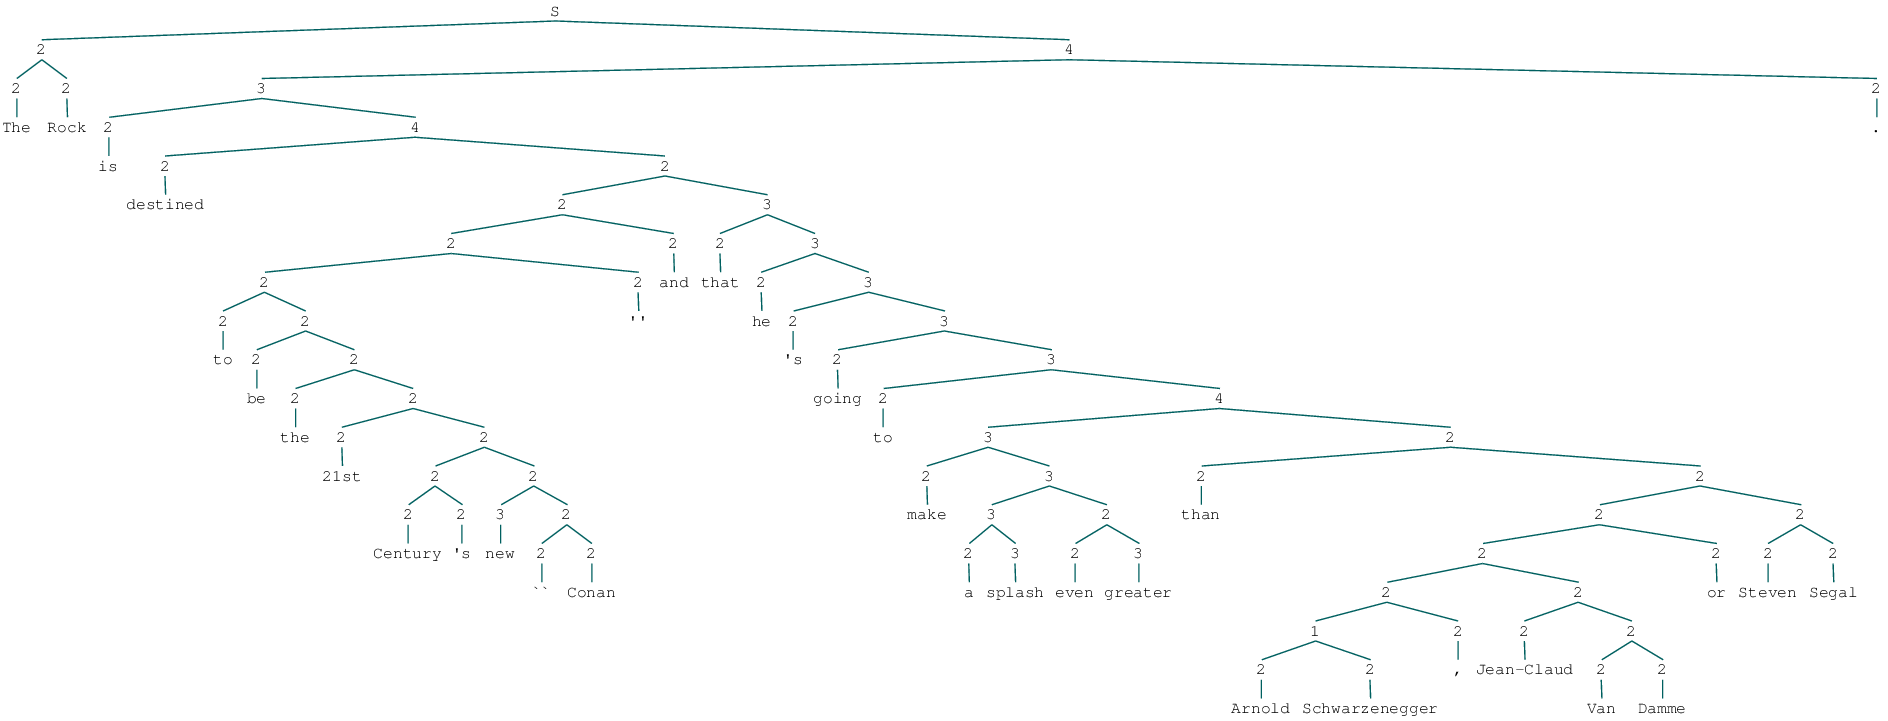

In [42]:
X_tree_train[0]

In [43]:
X_tree_dev, y_tree_dev = get_tree_dataset(sst.dev_reader)

### Pure NumPy TreeNN implementation

`TreeNN` is a pure NumPy implementation of this model. It should be regarded as a baseline for models of this form. The original SST paper includes evaluations of a wide range of models in this family.

In [44]:
tree_nn_glove = TreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    embed_dim=None,  # Ignored when embedding is not `None`
    hidden_dim=50,
    max_iter=10,
    eta=0.05) 

In [45]:
%time _ = tree_nn_glove.fit(X_tree_train, y_tree_train)

Finished epoch 10 of 10; error is 7.167385078020315

CPU times: user 6min 6s, sys: 22.7 s, total: 6min 28s
Wall time: 3min 18s


In [46]:
tree_glove_dev_predictions = tree_nn_glove.predict(X_tree_dev)

In [47]:
print(classification_report(y_tree_dev, tree_glove_dev_predictions))

              precision    recall  f1-score   support

    negative       0.75      0.01      0.03       428
    positive       0.51      1.00      0.68       444

   micro avg       0.51      0.51      0.51       872
   macro avg       0.63      0.50      0.35       872
weighted avg       0.63      0.51      0.36       872



### Torch TreeNN implementation

In [48]:
torch_tree_nn_glove = TorchTreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    hidden_dim=50,
    embed_dim=50,
    max_iter=10,
    eta=0.05)

In [49]:
%time _ = torch_tree_nn_glove.fit(X_tree_train, y_tree_train)

Finished epoch 10 of 10; error is 5.109200537204742

CPU times: user 12min 29s, sys: 50.1 s, total: 13min 19s
Wall time: 6min 33s


In [50]:
torch_tree_glove_dev_predictions = torch_tree_nn_glove.predict(X_tree_dev)

In [51]:
print(classification_report(y_tree_dev, torch_tree_glove_dev_predictions))

              precision    recall  f1-score   support

    negative       0.56      0.05      0.09       428
    positive       0.51      0.96      0.67       444

   micro avg       0.51      0.51      0.51       872
   macro avg       0.54      0.51      0.38       872
weighted avg       0.54      0.51      0.39       872

